# Malaysia Power – Generation vs Demand by Region

This notebook compares monthly generation and demand by region to
estimate how comfortably supply covers load (gen/demand ratio).


In [2]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

con = sqlite3.connect("/Users/praabz/Desktop/Malaysia power sql lab/malaysia_power.db")

pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", con)


,name
0,sqlite_stat1
1,sqlite_stat4
2,dim_date_month
3,dim_region
4,dim_fuel
5,emission_factor
6,fact_demand_monthly
7,fact_generation_monthly
8,fuel_price_monthly


In [7]:
query = """
SELECT
    d.year,
    d.month,
    r.region_name,
    SUM(g.mwh)             AS gen_mwh,
    SUM(dem.mwh_demand)    AS demand_mwh,
    SUM(g.mwh) * 1.0 / NULLIF(SUM(dem.mwh_demand), 0) AS gen_to_demand_ratio
FROM fact_generation_monthly g
JOIN dim_date_month d   ON g.date_id   = d.date_id
JOIN dim_region r       ON g.region_id = r.region_id
JOIN fact_demand_monthly dem
    ON dem.date_id = d.date_id
   AND dem.region_id = r.region_id
GROUP BY
    d.year,
    d.month,
    r.region_name
ORDER BY
    d.year,
    d.month,
    r.region_name;
"""

df = pd.read_sql(query, con)
df["year_month"] = df.apply(lambda r: f"{r['year']}-{r['month']:02d}", axis=1)
df.head()


,year,month,region_name,gen_mwh,demand_mwh,gen_to_demand_ratio,year_month
0,2024,1,Peninsular,725000.0,2060000.0,0.351942,2024-01
1,2024,1,Sabah,125000.0,515000.0,0.242718,2024-01
2,2024,1,Sarawak,175000.0,721000.0,0.242718,2024-01
3,2024,2,Peninsular,520000.0,2143600.0,0.242583,2024-02
4,2024,2,Sabah,130000.0,534500.0,0.243218,2024-02


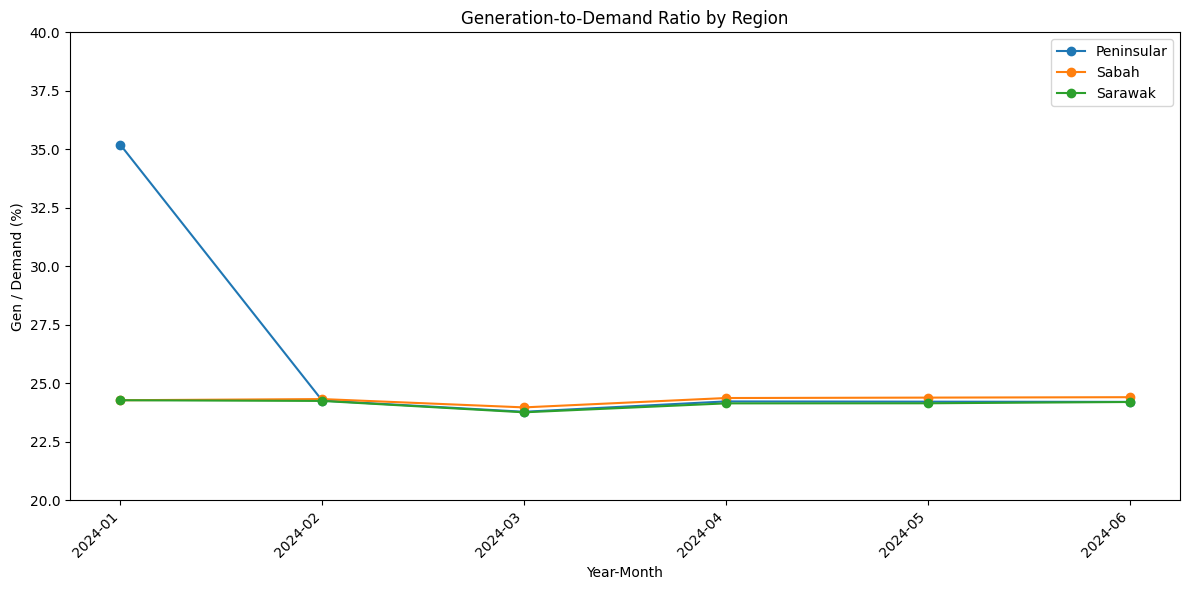

In [10]:
df["ratio_pct"] = df["gen_to_demand_ratio"] * 100

plt.figure(figsize=(12, 6))

for region, sub in df.groupby("region_name"):
    plt.plot(sub["year_month"], sub["ratio_pct"], marker="o", label=region)

plt.axhline(100, linestyle="--", color="gray", alpha=0.5)
plt.title("Generation-to-Demand Ratio by Region")
plt.xlabel("Year-Month")
plt.ylabel("Gen / Demand (%)")
plt.ylim(20, 40)     # zoom into real band
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.tight_layout()
plt.show()

